# Image Focus Checking

In [1]:
import cv2
import math
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

## Preprocessing the image

### Sharpening

In [2]:
def sharpen_image(image):
    sharp_img = cv2.filter2D(image, -1, np.array([[0,-1,0], [-1,5,-1], [0,-1,0]]))
    return sharp_img

### Canny Edge Detection to return the bounds of the these edges

In [12]:
def canny_segmentation(img, low_threshold=100, high_threshold=200):
    edges = cv2.Canny(img, low_threshold, high_threshold)
    return edges

def get_bounding_box(image,thresh=0.95):
    nonzero_indices = np.nonzero(image.T)    
    if len(nonzero_indices[0]) < 1 or len(nonzero_indices[1]) < 1:
        return (0, 0), (0, 0)
    min_row, max_row = np.min(nonzero_indices[0]), np.max(nonzero_indices[0])
    min_col, max_col = np.min(nonzero_indices[1]), np.max(nonzero_indices[1])
    box_size = max_row - min_row + 1, max_col - min_col + 1
    box_size_thresh = (int(box_size[0] * thresh), int(box_size[1] * thresh))
    #box_size_thresh = (int(box_size[0]), int(box_size[1]))
    #coordinates of the box that contains 95% of the highest pixel values
    top_left = (min_row + int((box_size[0] - box_size_thresh[0]) / 2), min_col + int((box_size[1] - box_size_thresh[1]) / 2))
    bottom_right = (top_left[0] + box_size_thresh[0], top_left[1] + box_size_thresh[1])
    return (top_left[0], top_left[1]), (bottom_right[0], bottom_right[1])

In [4]:
def read_image_rgb(path_to_image):
    return cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)

def create_gradient_image(size, offset, min_value=0, max_value=1):    
    gradient = np.concatenate((np.full(shape=int(offset/2),fill_value=min_value,dtype=np.double),
                               np.linspace(min_value, max_value, size-offset, endpoint=False),
                               np.full(shape=int(offset/2),fill_value=max_value,dtype=np.double)))
    gradient = np.tile(gradient, (size, 1))*255
    return gradient


def display_image(image, title='Image'):
    plt.imshow(image)
    plt.title(title)
    plt.show()
    
def show_1d_hist(image,channel=0):
    matplotlib.rcParams['figure.figsize'] = [5, 5]
    hist = cv2.calcHist([image],[channel],None,[256],[0,256])
    plt.plot(hist)
    plt.show()
    
def gaussian_blur(image, kernel_size=5, sigma=0):
    return cv2.GaussianBlur(image, (kernel_size,kernel_size), sigma)
    
    
def display_image_list(images, n_cols=5, labels=None):
    matplotlib.rcParams['figure.figsize'] = [10, 10]
    if (labels==None):
        labels = [str(l) for l in range(len(images))]
        
    n_rows = math.ceil(len(images)/n_cols)
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
    ax = axes.ravel()

    for i in range(0,len(images)):
        ax[i].imshow(images[i],cmap='gray')
        ax[i].set_title(labels[i])
        ax[i].axis('off')
    plt.show()

def is_blurry(image, thresh = 150, crop_edges_thresh = 0.75, canny_thresh_low = 100, canny_thresh_high = 200):
    if (len(image.shape)<3):
        gray = image
    else:        
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    
    gray = sharpen_image(gray)
    seg= canny_segmentation(gray,canny_thresh_low,canny_thresh_high)
    bb_thresh = get_bounding_box(seg,crop_edges_thresh)
    im_crop = gray[bb_thresh[0][1]:bb_thresh[1][1],bb_thresh[0][0]:bb_thresh[1][0]]      
    edges = cv2.Laplacian(im_crop, cv2.CV_64F)    
    return edges.var() < thresh

In [5]:
image_list = ['figs/1.png','figs/2.png','figs/3.png','figs/4.png','figs/5.png']
imgs = [read_image_rgb(img_path) for img_path in image_list]
labels = [f'Is blurry? {is_blurry(img)}' for img in imgs]

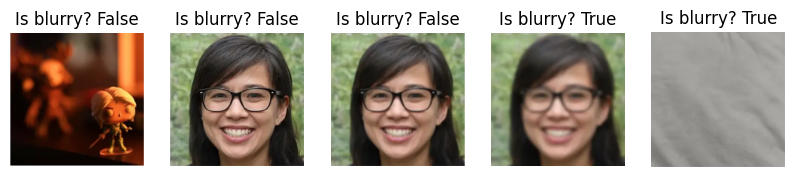

In [6]:
display_image_list(imgs,labels=labels)

Original image
Laplacian variance 1442.979227727963
Crop Laplacian variance 19.79896134434166


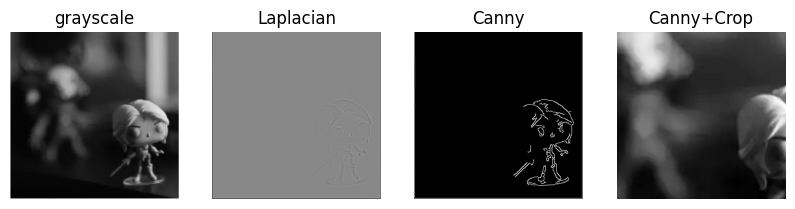

Sharepned image
Laplacian variance 3031.727300472961
Crop Laplacian variance 201.54120954979018


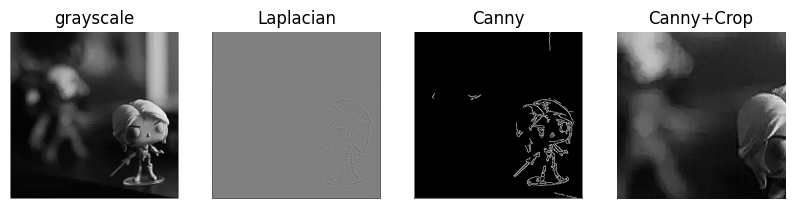

...
Original image
Laplacian variance 207.14496797464633
Crop Laplacian variance 421.8624173258273


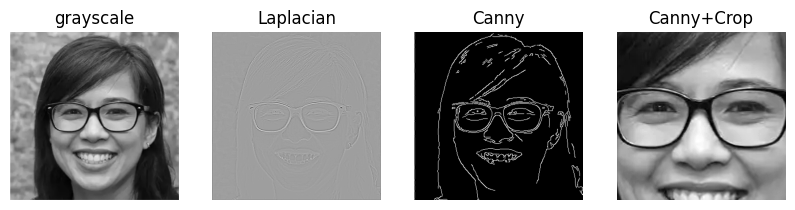

Sharepned image
Laplacian variance 2469.6252939639194
Crop Laplacian variance 3895.089626183149


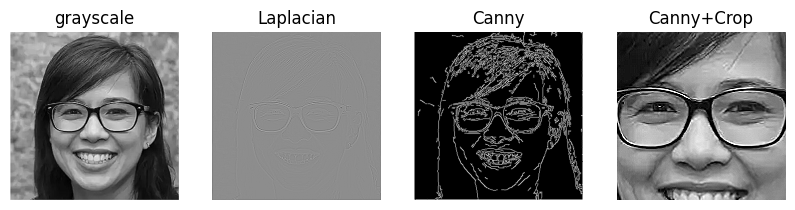

...
Original image
Laplacian variance 95.11634991582494
Crop Laplacian variance 46.24999043478481


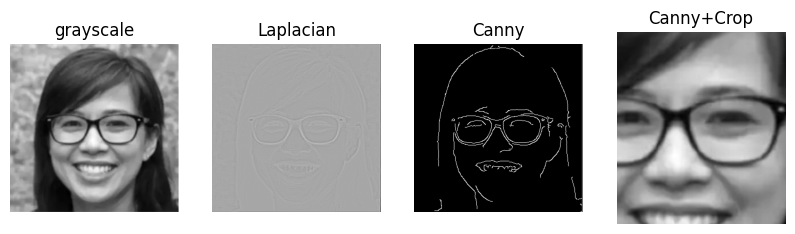

Sharepned image
Laplacian variance 771.0364472797171
Crop Laplacian variance 288.3125761399392


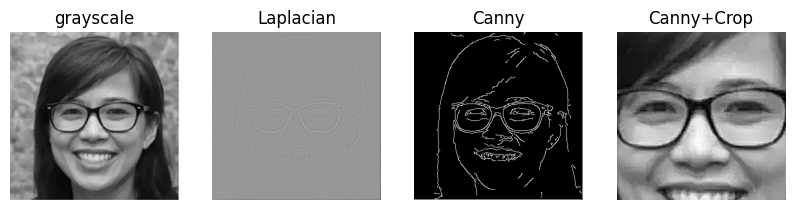

...
Original image
Laplacian variance 6.542689682749862
Crop Laplacian variance 112.56766528925621


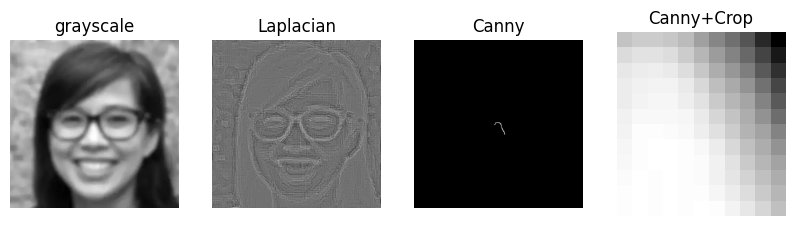

Sharepned image
Laplacian variance 101.3041254417138
Crop Laplacian variance 114.00636265913198


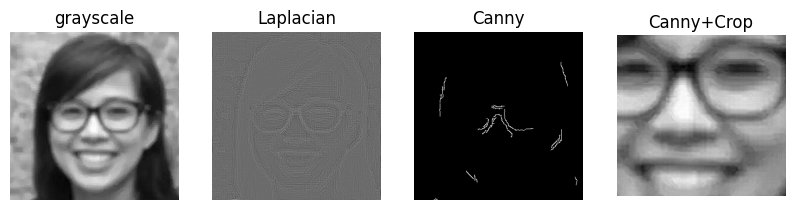

...
Original image
Laplacian variance 5.330202646304611


error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/deriv.cpp:792: error: (-215:Assertion failed) !_src.empty() in function 'Laplacian'


In [13]:
for img in imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Laplacian(gray, cv2.CV_64F)
    seg= canny_segmentation(gray)    
    bb_thresh = get_bounding_box(seg,0.5)
    im_crop = gray[bb_thresh[0][1]:bb_thresh[1][1],bb_thresh[0][0]:bb_thresh[1][0]]
    
    print('Original image')
    print(f'Laplacian variance {edges.var()}')    
    print(f'Crop Laplacian variance {cv2.Laplacian(im_crop, cv2.CV_64F).var()}') 
    display_image_list([gray,edges,seg,im_crop],4,['grayscale','Laplacian','Canny','Canny+Crop'])
    
    gray = cv2.cvtColor(cv2.filter2D(img, -1, np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])), cv2.COLOR_RGB2GRAY)
    edges = cv2.Laplacian(gray, cv2.CV_64F)
    seg= canny_segmentation(gray)
    bb_thresh = get_bounding_box(seg,0.5)
    im_crop = gray[bb_thresh[0][1]:bb_thresh[1][1],bb_thresh[0][0]:bb_thresh[1][0]]
    
    print('Sharepned image')
    print(f'Laplacian variance {edges.var()}')    
    print(f'Crop Laplacian variance {cv2.Laplacian(im_crop, cv2.CV_64F).var()}') 
    display_image_list([gray,edges,seg,im_crop],4,['grayscale','Laplacian','Canny','Canny+Crop'])
    print('...')

## References

* [Determine if an image is in focus using OpenCV](https://zahid-parvez.medium.com/finding-the-focus-determining-if-an-image-is-blurry-8f6c84fae47f)